<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/12_skimlit_nlp_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the Data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [3]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### preprocess Data

In [5]:
# Function to preprocess data

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [7]:
len(train_lines)

210040

In [8]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) -1 
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [10]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
import pandas as pd

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [15]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

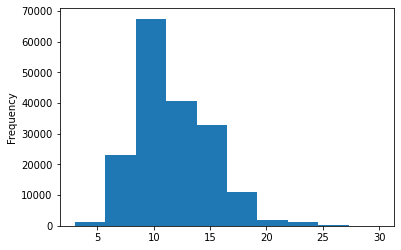

In [16]:
train_df.total_lines.plot.hist()

### get lists of sentences

In [17]:
train_sentences= train_df["text"].tolist()
val_sentences= val_df["text"].tolist()
test_sentences= test_df["text"].tolist()

In [18]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

### Make numeric Labels

In [20]:
# one hot Encoding of labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [21]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [22]:
import tensorflow as tf 
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [24]:
train_labels_encoded[:50]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4, 4, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 3, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 1, 1])

In [25]:
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 : Baseline model

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [27]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

In [28]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score*100

72.1832384482987

In [30]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

### Getting Helper Function

In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-07 04:45:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-07 04:45:53 (97.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [32]:
from helper_functions import calculate_results

In [33]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_pred)

In [34]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing the data for Deep Sequencing models

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [36]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [37]:
sent_lens[:5]

[49, 27, 15, 14, 35]

In [38]:
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len)

26

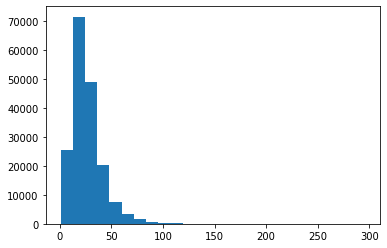

In [39]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [40]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

### Text Vectorizer Layer

In [41]:
max_tokens = 68000

In [42]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [43]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [44]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [45]:
!nvidia-smi

Sun Nov  7 04:46:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    35W / 250W |    361MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
import random
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence), text_vectorizer([target_sentence])

('we tested the moderating effect of three individual ( baseline depressive symptoms , negative attributional style , substance use ) , three environmental ( negative life events , parental support , peer support ) , and two sociodemographic ( sex , age ) characteristics .',
 271,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[   43,   567,     2,  7049,    70,     4,   134,   565,    49,
           649,   144,   469, 23818,  4807,  1604,    87,   134,  2810,
           469,   195,   124,  1755,   279,  2034,   279,     3,    51,
          4353,   693,   103,   395,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>)

In [47]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [48]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Creating a Embedding Layer

In [49]:
# token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="Token_embedding")

In [50]:
target_sentence, text_vectorizer([target_sentence]), token_embed(text_vectorizer([target_sentence]))

('we tested the moderating effect of three individual ( baseline depressive symptoms , negative attributional style , substance use ) , three environmental ( negative life events , parental support , peer support ) , and two sociodemographic ( sex , age ) characteristics .',
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[   43,   567,     2,  7049,    70,     4,   134,   565,    49,
           649,   144,   469, 23818,  4807,  1604,    87,   134,  2810,
           469,   195,   124,  1755,   279,  2034,   279,     3,    51,
          4353,   693,   103,   395,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>,
 <tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[ 7.33491033e-03, -3.17132249e-02,  4.26912345e-02, ...,
           1.62947811e-02,  1.04232654e-02, -2.76993401e-02],
         [-1.67127475e-02,  3.76188867e-0

In [51]:
token_embed(text_vectorizer([target_sentence])).shape

TensorShape([1, 55, 128])

### Better performances with tf datasets

In [52]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [53]:
train_datasets

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [54]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
valid_datasets = valid_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [55]:
train_datasets

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D

In [56]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [57]:
model_1.summary()

Model: "model_1_Conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
Token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [58]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_datasets,
            epochs=5,
            steps_per_epoch = int(0.1 * len(train_datasets)),
            validation_data=valid_datasets,
            validation_steps = int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 19s 6ms/step - loss: 0.9491 - accuracy: 0.6239 - val_loss: 0.7150 - val_accuracy: 0.7247
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6825 - accuracy: 0.7465 - val_loss: 0.6570 - val_accuracy: 0.7626
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6367 - accuracy: 0.7661 - val_loss: 0.6127 - val_accuracy: 0.7749
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6058 - accuracy: 0.7804 - val_loss: 0.5963 - val_accuracy: 0.7799
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.6020 - accuracy: 0.7893 - val_loss: 0.5733 - val_accuracy: 0.7975


In [59]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5720 - accuracy: 0.7977


[0.5719719529151917, 0.7976962924003601]

In [60]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.76962796239904,
 'f1': 0.7943181144355331,
 'precision': 0.7965509366547762,
 'recall': 0.7976962796239905}

In [61]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [63]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
model_1_1_history = model_1.fit(train_datasets,
            epochs=5,
            validation_data=valid_datasets,
            )

Epoch 1/5
5627/5627 [==============================] - 34s 6ms/step - loss: 0.5047 - accuracy: 0.8165 - val_loss: 0.5006 - val_accuracy: 0.8148
Epoch 2/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.3703 - accuracy: 0.8708 - val_loss: 0.5260 - val_accuracy: 0.8097
Epoch 3/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.2369 - accuracy: 0.9228 - val_loss: 0.6218 - val_accuracy: 0.7971
Epoch 4/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.1318 - accuracy: 0.9612 - val_loss: 0.7579 - val_accuracy: 0.7838
Epoch 5/5
5627/5627 [==============================] - 33s 6ms/step - loss: 0.0707 - accuracy: 0.9806 - val_loss: 0.9099 - val_accuracy: 0.7844


In [65]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.9099 - accuracy: 0.7844


[0.9099158644676208, 0.7844234108924866]

In [66]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.44234079173839,
 'f1': 0.7836406082287203,
 'precision': 0.7852284662800848,
 'recall': 0.7844234079173839}

### Model 2: Feature Extraction with pretrained token embeddings

In [67]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [68]:
# Model 2
model_2 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [70]:
model_2.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=3,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 0.9179 - accuracy: 0.6465 - val_loss: 0.7964 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7681 - accuracy: 0.7012 - val_loss: 0.7543 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7509 - accuracy: 0.7134 - val_loss: 0.7383 - val_accuracy: 0.7094


In [71]:
model_2.evaluate(valid_datasets)

945/945 [==============================] - 9s 10ms/step - loss: 0.7407 - accuracy: 0.7145


[0.7407183051109314, 0.7145174145698547]

In [72]:
model_2_pred_probs = model_2.predict(valid_datasets)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.45174103005428,
 'f1': 0.7114324577173806,
 'precision': 0.714788019928754,
 'recall': 0.7145174103005428}

In [73]:
# Making trainable=True
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="universal_sentence_encoder")

In [74]:
# Model 2_1
model_2_1 = tf.keras.Sequential([
                               tf_hub_embedding_layer,
                               layers.Dense(128, activation="relu"),
                               layers.Dense(5, activation="softmax")
])

model_2_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_2_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 256,864,133
Non-trainable params: 0
_________________________________________________________________


In [76]:
model_2_1.fit(train_datasets,
            steps_per_epoch=int(0.1 * len(train_datasets)),
            epochs=5,
            validation_data=valid_datasets,
            validation_steps=int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 52s 84ms/step - loss: 0.7444 - accuracy: 0.7112 - val_loss: 0.5601 - val_accuracy: 0.7839
Epoch 2/5
562/562 [==============================] - 46s 83ms/step - loss: 0.5583 - accuracy: 0.7954 - val_loss: 0.5248 - val_accuracy: 0.8002
Epoch 3/5
562/562 [==============================] - 46s 82ms/step - loss: 0.5281 - accuracy: 0.8037 - val_loss: 0.4986 - val_accuracy: 0.8102
Epoch 4/5
562/562 [==============================] - 46s 82ms/step - loss: 0.5016 - accuracy: 0.8166 - val_loss: 0.4766 - val_accuracy: 0.8185
Epoch 5/5
562/562 [==============================] - 46s 82ms/step - loss: 0.5026 - accuracy: 0.8166 - val_loss: 0.4862 - val_accuracy: 0.8155


In [77]:
model_2_1.evaluate(valid_datasets)

945/945 [==============================] - 9s 10ms/step - loss: 0.4907 - accuracy: 0.8156


[0.4907199740409851, 0.8156030774116516]

In [78]:
model_2_1_pred_probs = model_2_1.predict(valid_datasets)
model_2_1_preds = tf.argmax(model_2_1_pred_probs, axis=1)
model_2_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_1_preds)
model_2_1_results

{'accuracy': 81.56030716271681,
 'f1': 0.8183470214218386,
 'precision': 0.8303240806705827,
 'recall': 0.815603071627168}

### Model 3: Conv1D with character embeddings

In [79]:
# Function to split sentences to characters
def split_chars(text):
  return " ".join(list(text))

In [80]:
split_chars(target_sentence)

'w e   t e s t e d   t h e   m o d e r a t i n g   e f f e c t   o f   t h r e e   i n d i v i d u a l   (   b a s e l i n e   d e p r e s s i v e   s y m p t o m s   ,   n e g a t i v e   a t t r i b u t i o n a l   s t y l e   ,   s u b s t a n c e   u s e   )   ,   t h r e e   e n v i r o n m e n t a l   (   n e g a t i v e   l i f e   e v e n t s   ,   p a r e n t a l   s u p p o r t   ,   p e e r   s u p p o r t   )   ,   a n d   t w o   s o c i o d e m o g r a p h i c   (   s e x   ,   a g e   )   c h a r a c t e r i s t i c s   .'

In [81]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [82]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [83]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

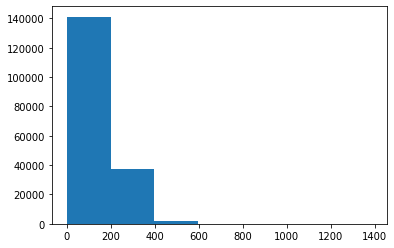

In [84]:
plt.hist(char_lens, bins=7);

In [85]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [87]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [88]:
len(alphabet), alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [90]:
NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [91]:
char_vectorizer.adapt(train_chars)

In [93]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab, len(char_vocab)

(['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'],
 28)

In [96]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   c   (   m a x   )   o f   d o c e t a x e l   w a s   @ , @   n g / m l   f o r   t e s t   d r u g   a n d   @ , @   n g / m l   f o r   r e f e r e n c e   d r u g   ,   a n d   t w o   d r u g s   s h o w e d   n o   d i f f e r e n c e   w i t h   a   s t a t i s t i c a l   s i g n i f i c a n c e   .

Length of chars: 128

Vectorized chars:
[[ 3 13  2 11 15  5 24  7 17 10  7 11  2  3  5 24  2 12 20  5  9  6 18 15
  12 17  7  8  3  2  9  3 10  8 16 18  5  6 10  6 18 15 12 17  7  8  8  2
  17  2  8  2  6 11  2 10  8 16 18  5  6 10  3 20  7 10  8 16 18  9  9 13
   7 20  2 10  6  7 10  4 17 17  2  8  2  6 11  2 20  4  3 13  5  9  3  5
   3  4  9  3  4 11  5 12  9  4 18  6  4 17  4 11  5  6 11  2  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 

In [94]:
# token embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=25,
                               mask_zero=True,
                               name="Char_embedding")

In [97]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   c   (   m a x   )   o f   d o c e t a x e l   w a s   @ , @   n g / m l   f o r   t e s t   d r u g   a n d   @ , @   n g / m l   f o r   r e f e r e n c e   d r u g   ,   a n d   t w o   d r u g s   s h o w e d   n o   d i f f e r e n c e   w i t h   a   s t a t i s t i c a l   s i g n i f i c a n c e   .

Embedded chars (after vectorization and embedding):
[[[-0.01645167 -0.01489838 -0.0482023  ...  0.03997036 -0.04933572
   -0.00957168]
  [-0.02452809  0.04488705 -0.00110099 ...  0.01040825 -0.03134719
    0.04665016]
  [-0.02956765 -0.02239827  0.04356196 ... -0.01210179  0.04358445
    0.02292247]
  ...
  [ 0.00786315  0.01057144 -0.04361329 ...  0.02090294  0.03393829
    0.04330281]
  [ 0.00786315  0.01057144 -0.04361329 ...  0.02090294  0.03393829
    0.04330281]
  [ 0.00786315  0.01057144 -0.04361329 ...  0.02090294  0.03393829
    0.04330281]]]

Character embedding shape: (1, 290, 25)


In [108]:
# Model 3
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv_1d")

In [109]:
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [110]:
model_3.summary()

Model: "model_3_conv_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
Char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________

In [111]:
train_char_datasets = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_datasets = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_datasets = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [105]:
val_chars[0]

'i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .'

In [112]:
model_3_history = model_3.fit(train_char_datasets,
                              steps_per_epoch=int(0.1*len(train_char_datasets)),
                              epochs=5,
                              validation_data=val_char_datasets,
                              validation_steps=int(0.1*len(val_char_datasets)))

Epoch 1/5
562/562 [==============================] - 3s 5ms/step - loss: 1.2172 - accuracy: 0.5024 - val_loss: 1.0755 - val_accuracy: 0.5748
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0545 - accuracy: 0.5753 - val_loss: 0.9875 - val_accuracy: 0.6054
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9817 - accuracy: 0.6152 - val_loss: 0.9300 - val_accuracy: 0.6410
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9202 - accuracy: 0.6427 - val_loss: 0.8827 - val_accuracy: 0.6599
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9027 - accuracy: 0.6476 - val_loss: 0.8575 - val_accuracy: 0.6656


In [113]:
model_3.evaluate(val_char_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.8749 - accuracy: 0.6631


[0.8748683333396912, 0.6630808711051941]

In [115]:
model_3_pred_probs = model_3.predict(val_char_datasets)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.30808950086059,
 'f1': 0.6603254728838844,
 'precision': 0.6690500077188283,
 'recall': 0.6630808950086059}

### Model 4: Combining pretrained token embeddings and characters embeddings

In [120]:
# Model 4

#1. Setup token inputs/Model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

#2. Setup Char inputs/models
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#3. concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_concate")([token_model.output,
                                                                   char_model.output])

#4. Create outputs layers- adding in droupouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

#5.model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")



In [121]:
# compile the model
model_4.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [122]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

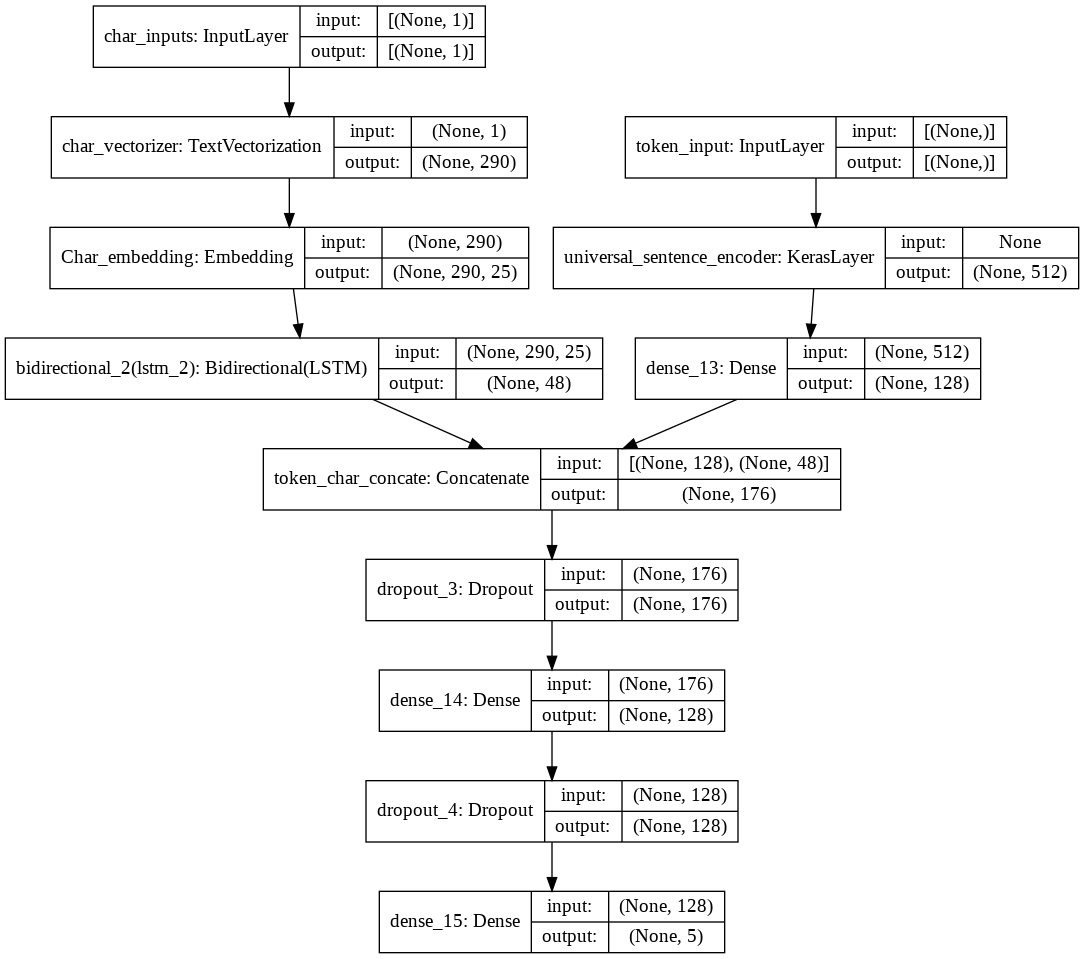

In [126]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [129]:
# Combine chars and tokens into single inputs
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [131]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 76s 117ms/step - loss: 0.4286 - accuracy: 0.8577 - val_loss: 0.5673 - val_accuracy: 0.8238
Epoch 2/5
562/562 [==============================] - 64s 114ms/step - loss: 0.2648 - accuracy: 0.9169 - val_loss: 0.6351 - val_accuracy: 0.8005
Epoch 3/5
562/562 [==============================] - 62s 110ms/step - loss: 0.2453 - accuracy: 0.9246 - val_loss: 0.6114 - val_accuracy: 0.7982
Epoch 4/5
562/562 [==============================] - 65s 116ms/step - loss: 0.2261 - accuracy: 0.9291 - val_loss: 0.6350 - val_accuracy: 0.8072
Epoch 5/5
562/562 [==============================] - 63s 112ms/step - loss: 0.2387 - accuracy: 0.9289 - val_loss: 0.6472 - val_accuracy: 0.8025


In [132]:
!nvidia-smi

Sun Nov  7 07:33:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    37W / 250W |   9051MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [133]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.6549 - accuracy: 0.7937


[0.654919445514679, 0.7936912775039673]

In [134]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 79.36912485105256,
 'f1': 0.7953354833550482,
 'precision': 0.804074644346344,
 'recall': 0.7936912485105256}